### Import modules and set torch random seed

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import random

torch.manual_seed(42)

### Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Unzip dataset into /content

In [3]:
!rm -rf '/content/data'
!unzip '/content/drive/My Drive/APS 360/Project/Data Final/data_masked.zip' -d '/content/data' # store dataset in your own drive

Streaming output truncated to the last 5000 lines.
 extracting: /content/data/data_masked/train/3/297 (5).png  
 extracting: /content/data/data_masked/train/3/297 (6).png  
 extracting: /content/data/data_masked/train/3/297.png  
 extracting: /content/data/data_masked/train/3/298 (10).png  
 extracting: /content/data/data_masked/train/3/298 (11).png  
 extracting: /content/data/data_masked/train/3/298 (13).png  
 extracting: /content/data/data_masked/train/3/298 (2).png  
 extracting: /content/data/data_masked/train/3/298 (3).png  
 extracting: /content/data/data_masked/train/3/298 (5).png  
 extracting: /content/data/data_masked/train/3/299 (10).png  
 extracting: /content/data/data_masked/train/3/299 (11).png  
 extracting: /content/data/data_masked/train/3/299 (2).png  
 extracting: /content/data/data_masked/train/3/299 (3).png  
 extracting: /content/data/data_masked/train/3/299 (5).png  
 extracting: /content/data/data_masked/train/3/299 (6).png  
 extracting: /content/data/data_m

### Load dataset

In [4]:
main_path = '/content/data/data_masked' # store file path in variable for convenience

transform = transforms.Compose([
    transforms.Resize((120, 120)),                                      # Resize to some dimension depending on input size to neural network
    transforms.ToTensor(),                                              # Convert image to a torch tensor
])

classes = ["Gen 1", "Gen 2", "Gen 3", "Gen 4/5", "Gen6/7"]

train_dataset = torchvision.datasets.ImageFolder(main_path + '/train', transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(main_path + '/val', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(main_path + '/test', transform=transform)

### Verify dataset

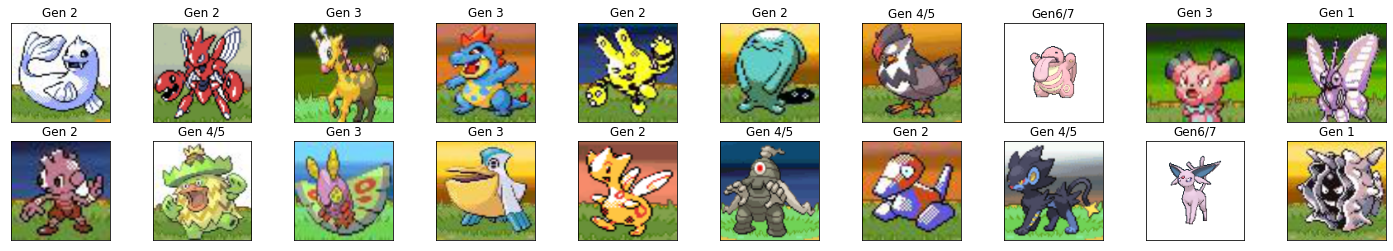

In [5]:
# verify images by viewing a small batch
verif_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=1, shuffle=True)

dataiter = iter(verif_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = images[idx]
    lbl = labels[idx]
    conv = np.transpose(img, (1, 2, 0))
    plt.imshow(conv)
    ax.set_title(classes[lbl])

In [6]:
dataset_size = len(train_dataset)
classes = train_dataset.classes
num_classes = len(train_dataset.classes)
img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0

for i in range(dataset_size):
    img, label = train_dataset[i]
    img_dict[classes[label]] += 1

print(img_dict)

global weights
weights = torch.tensor([dataset_size/5/img_dict[str(i)] for i in range(0,5)]).cuda() # credit: https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
print(weights)
global criterion
criterion = nn.CrossEntropyLoss(weight=weights)

{'0': 362, '1': 816, '2': 982, '3': 3832, '4': 1049}
tensor([3.8901, 1.7257, 1.4340, 0.3675, 1.3424], device='cuda:0')


### Training functions

In [7]:
# evaluate model performance (loss and accuracy)
def evaluate(model, data_loader, y_pred, y_true, cm):
    total_loss = 0.0
    correct = 0.0
    total = 0.0
    i=0

    for i, data in enumerate(data_loader, 0):
        imgs, labels = data

        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)             # forward pass
        loss = criterion(output, labels) # compute loss

        pred = output.max(1, keepdim=True)[1]         #select index with maximum prediction score
        if cm == True:
          y_true += labels.view_as(pred)
          y_pred += pred
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]


        total_loss += loss.item()

    # compute model loss
    model_loss = float(total_loss) / (i + 1)

    # compute model accuracy
    model_acc = (float(correct)) / total
        
    return model_acc, model_loss

In [ ]:
# train neural network
def train(train_pred, train_true, valid_pred, valid_true, model, train_loader, val_loader, batch_size=27, num_epochs=1, learn_rate = 0.001, weight_decay=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learn_rate, weight_decay=weight_decay)

    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    # training
    print ("Training Started...")
    print("COLUMNS: EPOCH NUMBER, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS")
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
        
        # save the current training information
        cm = False
        if epoch == num_epochs-1:
          cm = True
        tmp1, tmp2 = evaluate(model, train_loader, train_pred, train_true,cm)
        train_acc.append(tmp1)
        train_loss.append(tmp2)
        tmp1, tmp2 = evaluate(model, val_loader, valid_pred, valid_true, cm)
        val_acc.append(tmp1)
        val_loss.append(tmp2)

        print("%d \t\t %10.9f \t\t %10.7f \t\t %10.9f \t\t %10.7f" % (epoch, train_acc[-1], train_loss[-1], val_acc[-1], val_loss[-1]))
          
    plot_curves(model, train_acc, val_acc, train_loss, val_loss)

In [ ]:
# plot model performance across epochs
def plot_curves(model, train_acc, val_acc, train_loss, val_loss):
    n = len(train_acc) # number of epochs

    plt.title("Model Loss")
    plt.plot(range(1,1+n), train_loss, label="Train")
    plt.plot(range(1,1+n), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    print("Final Training Loss: {}".format(train_loss[-1]))
    print("Final Validation Loss: {}".format(val_loss[-1]))
    #plt.savefig(model.name + "loss") -> fix later

    plt.title("Model Accuracy")
    plt.plot(range(1,1+n), train_acc, label="Train")
    plt.plot(range(1,1+n), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    #plt.savefig(model.name + "acc") -> fix later

### Baseline model (ANN)

In [8]:
# Network architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.name = "ann"
        self.fc1 = nn.Linear(3 * 120 * 120, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, 5)

    def forward(self, img):
        x = img.view(-1, 3 * 120 * 120)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

CUDA Available! Using GPU...
Training Started...
COLUMNS: EPOCH NUMBER, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
0 		 0.201959949 		  1.5382987 		 0.193877551 		  1.5462187
1 		 0.553330493 		  1.5973750 		 0.544784580 		  1.6121033
2 		 0.165175401 		  1.4665690 		 0.162698413 		  1.4972905
3 		 0.313449794 		  1.3988950 		 0.290816327 		  1.4475627
4 		 0.472660134 		  1.3305862 		 0.462585034 		  1.3788472
5 		 0.539980116 		  1.3462959 		 0.538548753 		  1.4175159
6 		 0.283198409 		  1.2658492 		 0.257369615 		  1.3293355
7 		 0.421531033 		  1.2278754 		 0.382086168 		  1.3169333
8 		 0.549211760 		  1.2231571 		 0.510770975 		  1.3317028
9 		 0.287175117 		  1.3090599 		 0.250000000 		  1.4612311
10 		 0.555602897 		  1.1644436 		 0.524376417 		  1.2744277
11 		 0.519954552 		  1.1201206 		 0.469954649 		  1.2626116
12 		 0.482885954 		  1.0864466 		 0.441043084 		  1.2260659
13 		 0.404203948 		  1.1610987 		 0.362811791 		  1.3124998
14 		 0.52591

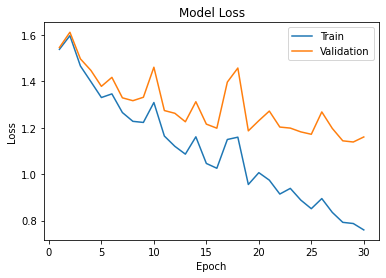

Final Training Loss: 0.7596645682781666
Final Validation Loss: 1.1605195594685418


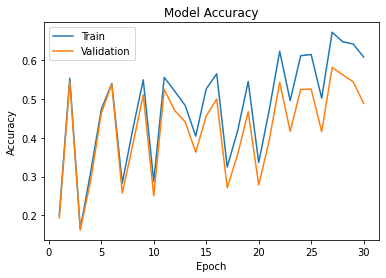

Final Training Accuracy: 0.608010225820196
Final Validation Accuracy: 0.4886621315192744
Training Confusion Matrix:
 [[ 337    4   15    3    3]
 [  33  716   46   13    8]
 [  12   29  768  115   58]
 [  75  154 1164 1836  603]
 [   4   12  123  286  624]]
Validation Confusion Matrix:
 [[ 44  27  14   4   2]
 [ 26 126  31  12  10]
 [ 15  19 142  48  22]
 [ 22  30 309 434 164]
 [  1   3  49  94 116]]


In [ ]:
use_cuda = True

# hyper parameters
bs = 64
lr = 0.0001
nw = 1
ep = 30
wd = 1e-5


# prepare dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, num_workers=nw, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, num_workers=nw, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, num_workers=nw, shuffle=True)

# create model
ann = ANNClassifier()
if use_cuda and torch.cuda.is_available():
    print("CUDA Available! Using GPU...")
    ann = ann.cuda()

# reset confusion matrix arrays
train_true = []
train_pred = []
valid_true = []
valid_pred = []

# train model
train(train_pred, train_true, valid_pred, valid_true, ann, train_loader, val_loader, batch_size=bs, num_epochs=ep, learn_rate = lr, weight_decay= wd)

train_true = [i.cpu().item() for i in train_true] 
train_pred = [i.cpu().item() for i in train_pred]
valid_true = [i.cpu().item() for i in valid_true] 
valid_pred = [i.cpu().item() for i in valid_pred]

# generate confusion matrices
train_cm = confusion_matrix(train_true, train_pred)
valid_cm = confusion_matrix(valid_true, valid_pred)
print("Training Confusion Matrix:\n", train_cm)
print("Validation Confusion Matrix:\n", valid_cm)

### Primary Model 1 (CNN)

In [9]:
# Network architecture
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.conv3 = nn.Conv2d(10, 15, 5)

        self.fc1 = nn.Linear(15 * 11 * 11, 32)
        self.fc2 = nn.Linear(32, 5)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = x.view(-1, 15 * 11 * 11)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

CUDA Available! Using GPU...
Training Started...
COLUMNS: EPOCH NUMBER, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
0 		 0.632296549 		  1.0319817 		 0.632086168 		  1.0646077
1 		 0.529896322 		  0.8849288 		 0.535714286 		  0.9006655
2 		 0.618236046 		  0.7616702 		 0.607142857 		  0.8051776
3 		 0.800454481 		  0.5393190 		 0.790816327 		  0.5871004
4 		 0.834966624 		  0.4261301 		 0.814625850 		  0.4679418
5 		 0.739383610 		  0.4103120 		 0.723922902 		  0.4884535
6 		 0.806703593 		  0.4325202 		 0.801020408 		  0.4890147
7 		 0.802016759 		  0.3488969 		 0.783446712 		  0.4297534
8 		 0.679448942 		  0.4510677 		 0.671768707 		  0.5386507
9 		 0.909955972 		  0.2366553 		 0.887755102 		  0.3212587
10 		 0.846186621 		  0.2595143 		 0.819160998 		  0.3950133
11 		 0.865644085 		  0.2414741 		 0.844671202 		  0.3697067
12 		 0.933958245 		  0.2186521 		 0.893424036 		  0.3569799
13 		 0.954409885 		  0.1227484 		 0.924036281 		  0.2244210
14 		 0.92898

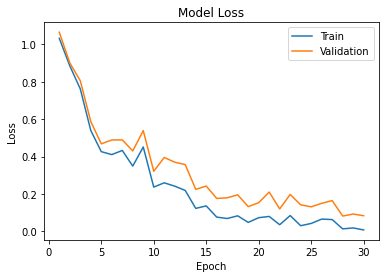

Final Training Loss: 0.007576565698111644
Final Validation Loss: 0.0834687529270079


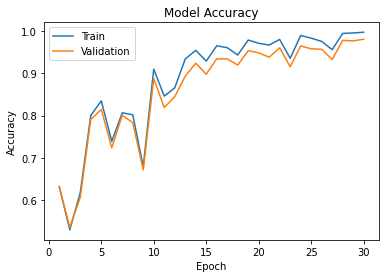

Final Training Accuracy: 0.9971594943900014
Final Validation Accuracy: 0.9807256235827665
Training Confusion Matrix:
 [[ 362    0    0    0    0]
 [   0  816    0    0    0]
 [   0    0  980    2    0]
 [   0    1    4 3822    5]
 [   0    0    0    8 1041]]
Validation Confusion Matrix:
 [[ 87   2   2   0   0]
 [  4 200   0   1   0]
 [  0   1 242   3   0]
 [  1   5   2 947   4]
 [  0   0   0   9 254]]


In [ ]:
use_cuda = True

# hyper parameters
bs = 16
lr = 0.0015
nw = 1
ep=30
wd = 5e-5

# prepare dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, num_workers=nw, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, num_workers=nw, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, num_workers=nw, shuffle=True)

# create model
cnn = CNNClassifier()
if use_cuda and torch.cuda.is_available():
    print("CUDA Available! Using GPU...")
    cnn = cnn.cuda()

# reset confusion matrix arrays
train_true = []
train_pred = []
valid_true = []
valid_pred = []

# train model
train(train_pred, train_true, valid_pred, valid_true, cnn, train_loader, val_loader, batch_size=bs, num_epochs=ep, learn_rate = lr, weight_decay= wd)

train_true = [i.cpu().item() for i in train_true] 
train_pred = [i.cpu().item() for i in train_pred]
valid_true = [i.cpu().item() for i in valid_true] 
valid_pred = [i.cpu().item() for i in valid_pred]

# generate confusion matrices
train_cm = confusion_matrix(train_true, train_pred)
valid_cm = confusion_matrix(valid_true, valid_pred)
print("Training Confusion Matrix:\n", train_cm)
print("Validation Confusion Matrix:\n", valid_cm)

### Primary Model 2 (AlexNet)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),                                      # Resize to some dimension depending on input size to neural network
    transforms.ToTensor(),                                              # Convert image to a torch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

])

train_dataset = torchvision.datasets.ImageFolder('/content/data/data_masked' + '/train', transform=transform)
valid_dataset = torchvision.datasets.ImageFolder('/content/data/data_masked' + '/val', transform=transform)
test_dataset = torchvision.datasets.ImageFolder('/content/data/data_masked' + '/test', transform=transform)

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)

!rm -rf 'AlexNet Features'

# save location
master_path = '/content/AlexNet Features'

if not os.path.isdir(master_path):
  os.mkdir(master_path)

# Prepare Dataloaders
batch_size = 1 # save 1 file at a time, hence batch_size = 1
num_workers = 1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [10]:
def save_features (data_loader, master_path):
  classes = ['0', '1', '2', '3', '4']

  if not os.path.isdir(master_path):
    os.mkdir(master_path)

  # save features to folder as tensors
  n = 0
  for img, label in (data_loader):
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = master_path + '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

In [ ]:
save_features(train_loader, master_path + "/train")
save_features(val_loader, master_path + "/val")
save_features(test_loader, master_path + "/test")

In [12]:
# Load Tensor Files (features) from folder

def load_features (master_path, batch_size):

  #load features
  dataset = torchvision.datasets.DatasetFolder(master_path, loader=torch.load, extensions=('.tensor'))

  # Prepare Dataloader
  num_workers = 1
  feature_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               num_workers=num_workers, shuffle=True)

  # Verification Step - obtain one batch of features
  dataiter = iter(feature_loader)
  features, labels = dataiter.next()
  print(features.shape)
  print(labels.shape)

  return feature_loader

In [ ]:
load_features(master_path + "/train", 32)
load_features(master_path + "/val", 32)
load_features(master_path + "/test",32)

torch.Size([32, 256, 6, 6])
torch.Size([32])
torch.Size([32, 256, 6, 6])
torch.Size([32])
torch.Size([32, 256, 6, 6])
torch.Size([32])


In [11]:
class AlexClassifier(nn.Module):
    def __init__(self):
        super(AlexClassifier, self).__init__()
        self.name = "alex"

        #self.conv1 = nn.Conv2d(256, 128, 3)
        #self.pool =  nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 6 * 6, 64)
        self.fc2 = nn.Linear(64, 5) # 5 classifications
    
    def forward(self, imgfeat):
        #x = self.pool(F.relu(self.conv1(imgfeat)))

        x = imgfeat.view(-1, 256 * 6 * 6)
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)
        return x

torch.Size([16, 256, 6, 6])
torch.Size([16])
torch.Size([16, 256, 6, 6])
torch.Size([16])
torch.Size([16, 256, 6, 6])
torch.Size([16])
Training Started...
COLUMNS: EPOCH NUMBER, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
0 		 0.770203096 		  0.7246981 		 0.752834467 		  0.7645251
1 		 0.824030677 		  0.5081007 		 0.791383220 		  0.5761920
2 		 0.853713961 		  0.3966901 		 0.815192744 		  0.4773160
3 		 0.869336742 		  0.3316768 		 0.816893424 		  0.4312880
4 		 0.924442551 		  0.2897045 		 0.863945578 		  0.4075790
5 		 0.928419259 		  0.2415219 		 0.866780045 		  0.3626801
6 		 0.940775458 		  0.2130394 		 0.875850340 		  0.3395723
7 		 0.944610141 		  0.1865332 		 0.875283447 		  0.3216035
8 		 0.962221275 		  0.1671601 		 0.890022676 		  0.3159336
9 		 0.969180514 		  0.1469422 		 0.905328798 		  0.3012207
10 		 0.968896464 		  0.1306574 		 0.907029478 		  0.2851752
11 		 0.976139753 		  0.1202140 		 0.907029478 		  0.2873713
12 		 0.979548360 		  0.10466

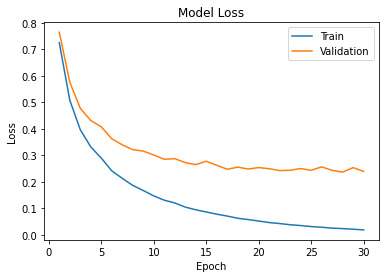

Final Training Loss: 0.01847131240715921
Final Validation Loss: 0.23905409228157354


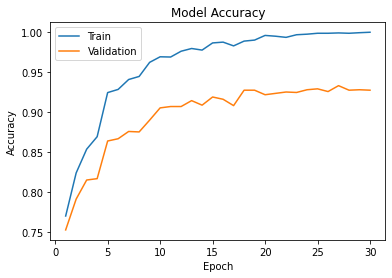

Final Training Accuracy: 0.9998579747195001
Final Validation Accuracy: 0.927437641723356
Training Confusion Matrix:
 [[ 362    0    0    0    0]
 [   0  816    0    0    0]
 [   0    0  982    0    0]
 [   0    0    1 3831    0]
 [   0    0    0    0 1049]]
Validation Confusion Matrix:
 [[ 78   8   5   0   0]
 [ 10 189   1   5   0]
 [  2   4 198  42   0]
 [  0   2  25 916  16]
 [  0   0   0   8 255]]


In [ ]:
use_cuda = True

# tuned hyper parameters
bs = 16
lr = 1e-5
ep = 30
wd = 1e-5

# load features for each dataset
train_loader = load_features(master_path + "/train", bs)
val_loader = load_features(master_path + "/val", bs)
test_loader = load_features(master_path + "/test", bs)

# create network
alex = AlexClassifier()
if use_cuda and torch.cuda.is_available():
    alex = alex.cuda()

# reset confusion matrix arrays
train_true = []
train_pred = []
valid_true = []
valid_pred = []

# train model
train(train_pred, train_true, valid_pred, valid_true, alex, train_loader, val_loader, batch_size=bs, num_epochs=ep, learn_rate = lr, weight_decay= wd)

train_true = [i.cpu().item() for i in train_true] 
train_pred = [i.cpu().item() for i in train_pred]
valid_true = [i.cpu().item() for i in valid_true] 
valid_pred = [i.cpu().item() for i in valid_pred]

# generate confusion matrices
train_cm = confusion_matrix(train_true, train_pred)
valid_cm = confusion_matrix(valid_true, valid_pred)
print("Training Confusion Matrix:\n", train_cm)
print("Validation Confusion Matrix:\n", valid_cm)

### Save models

In [ ]:
torch.save(ann, '/content/drive/My Drive/APS 360/Project/Data Final/ANN state/ann_model.pt')
torch.save(cnn, '/content/drive/My Drive/APS 360/Project/Data Final/CNN state/cnn_model.pt')
torch.save(alex, '/content/drive/My Drive/APS 360/Project/Data Final/AlexNet state/alexnet_model.pt')

### Load models

In [13]:
use_cuda = True

ann_new = torch.load('/content/drive/My Drive/APS 360/Project/Data Final/ANN state/ann_model.pt')
ann_new.eval()

cnn_new = torch.load('/content/drive/My Drive/APS 360/Project/Data Final/CNN state/cnn_model.pt')
cnn_new.eval()

alex_new = torch.load('/content/drive/My Drive/APS 360/Project/Data Final/AlexNet state/alexnet_model.pt')
alex_new.eval()

AlexClassifier(
  (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)

### Get testing accuracies

In [14]:
def test_model (model, loader):
  test_pred = []
  test_true = []

  test_acc, test_loss = evaluate(model, loader, test_pred, test_true, True)

  print("Final Testing Loss: {}".format(test_loss))
  print("Final Testing Accuracy: {}".format(test_acc))

  test_true = [i.cpu().item() for i in test_true] 
  test_pred = [i.cpu().item() for i in test_pred]

  # generate confusion matrices
  test_cm = confusion_matrix(test_true, test_pred)
  print("Testing Confusion Matrix:\n", test_cm)

  return test_true, test_pred

In [15]:
# ANN testing accuracy

transform = transforms.Compose([
    transforms.Resize((120, 120)),                                      # Resize to some dimension depending on input size to neural network
    transforms.ToTensor(),                                              # Convert image to a torch tensor
])

main_path = '/content/data/data_masked'
test_dataset = torchvision.datasets.ImageFolder(main_path + '/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=1, shuffle=True)

_, _ = test_model (ann_new, test_loader)

Final Testing Loss: 2.063824862241745
Final Testing Accuracy: 0.27
Testing Confusion Matrix:
 [[11 20  8  1  0]
 [ 4 27  3  4  2]
 [ 2 23 11  3  1]
 [ 4 21  8  5  2]
 [ 2 22 10  6  0]]


In [16]:
# AlexNet testing accuracy

transform = transforms.Compose([
    transforms.Resize((224, 224)),                                      # Resize to some dimension depending on input size to neural network
    transforms.ToTensor(),                                              # Convert image to a torch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

])

test_dataset = torchvision.datasets.ImageFolder('/content/data/data_masked' + '/test', transform=transform)

!rm -rf 'AlexNet Features_test'

# save location
master_path = '/content/AlexNet Features_test'

if not os.path.isdir(master_path):
  os.mkdir(master_path)

# Prepare Dataloaders
batch_size = 1 # save 1 file at a time, hence batch_size = 1
num_workers = 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

alexnet = torchvision.models.alexnet(pretrained=True)
save_features(test_loader, master_path + "/test")
load_features(master_path + "/test",32)

test_loader = load_features(master_path + "/test", 16)

_, _ = test_model (alex_new, test_loader)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



torch.Size([32, 256, 6, 6])
torch.Size([32])
torch.Size([16, 256, 6, 6])
torch.Size([16])
Final Testing Loss: 1.035816103219986
Final Testing Accuracy: 0.685
Testing Confusion Matrix:
 [[21  3 16  0  0]
 [ 0 31  9  0  0]
 [ 1  3 36  0  0]
 [ 2  3 24 11  0]
 [ 0  1  0  1 38]]


In [17]:
# CNN testing accuracy

transform = transforms.Compose([
    transforms.Resize((120, 120)),                                      # Resize to some dimension depending on input size to neural network
    transforms.ToTensor(),                                              # Convert image to a torch tensor
])

main_path = '/content/data/data_masked'
test_dataset = torchvision.datasets.ImageFolder(main_path + '/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, num_workers=1, shuffle=False)

tt, tp = test_model (cnn_new, test_loader)

Final Testing Loss: 1.3904670694699655
Final Testing Accuracy: 0.74
Testing Confusion Matrix:
 [[33  2  4  1  0]
 [ 5 27  5  3  0]
 [ 6  0 27  7  0]
 [ 6  1 11 21  1]
 [ 0  0  0  0 40]]


### Get examples of correct/incorrect classifications and generate feature maps 

In [ ]:
# get examples of correctly and incorrectly classified sprites

norm = [tt[j] == tp[j] for j in range(len(tt))]
corr = [i for i, e in enumerate(norm) if e == True]
incorr = [i for i, e in enumerate(norm) if e == False]

for i in [random.sample(corr, 2), random.sample(incorr, 2)]:
  for j in i:
    data_entry = test_dataset[j]
    plt.imshow(np.transpose(data_entry[0], (1, 2, 0)))
    print("True: %d\tPred: %d" %(data_entry[1], tp[j]))
    plt.show()

In [ ]:
# generate feature maps
import scipy.signal as sg

k1 = cnn_new.conv1.weight.detach().cpu()
k2 = cnn_new.conv2.weight.detach().cpu()
k3 = cnn_new.conv3.weight.detach().cpu()

bulb_class0 = train_dataset[2][0]
bulb_class0 = np.array(bulb_class0)
bulb_class0 = np.transpose(bulb_class0, (1,2,0))

bulb_class1 = train_dataset[362][0]
bulb_class1 = np.array(bulb_class1)
bulb_class1 = np.transpose(bulb_class1, (1,2,0))

bulb_class2 = train_dataset[1178][0]
bulb_class2 = np.array(bulb_class2)
bulb_class2 = np.transpose(bulb_class2, (1,2,0))

bulb_class3 = train_dataset[2160][0]
bulb_class3 = np.array(bulb_class3)
bulb_class3 = np.transpose(bulb_class3, (1,2,0))

bulb_class4 = train_dataset[5992][0]
bulb_class4 = np.array(bulb_class4)
bulb_class4 = np.transpose(bulb_class4, (1,2,0))

bulb_imgs = [bulb_class0, bulb_class1, bulb_class2, bulb_class3, bulb_class4]

for bulb in bulb_imgs:
  plt.title("Image")
  plt.imshow(bulb)
  plt.show()

  for i in [5,10,15]:
    kernels = None
    if i == 5:
      kernels = k1
    elif i == 10:
      kernels = k2
    else:
      kernels = k3

    fig = plt.figure()
    fig.set_figheight(120)
    fig.set_figwidth(120)

    for j in range(0,i):
      k = kernels[j][0]

      img_k = sg.convolve(bulb, k[..., None])
      img_k[img_k > 1] = 1
      img_k[img_k < 0] = 0
      plt.title("Feature Map for Kernel %d of Layer %d" %(j+1, i/5))
      plt.subplot(1,i,j+1)
      plt.imshow(img_k)

  plt.show()